## Create a map of Modis (3-Day) SST with SSMI Ice overlay for Arctic

This was a Salo product that used to be made. (she used 3days?)

Grab eight days of SST data and make a composite plot (averaging where multiple pixels are)
- Datasets from PODACC
- seems following page needs to be open for data to SST transfer - https://nsidc.org/data/NSIDC-0081/versions/1

Grab MODIS eight day product and overlay SST

In [16]:
%matplotlib inline

In [17]:
#using xarray for data read
import xarray as xa
import numpy as np
import pandas as pd
#using Cartopy for mapping
import matplotlib.pyplot as plt
import cmocean
import datetime

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


In [18]:
def make_map(projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(13, 8),
                           subplot_kw=dict(projection=projection))
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='1.0')
cmap = cmocean.cm.thermal


In [33]:
server='https://coastwatch.pfeg.noaa.gov/erddap',
protocol='tabledap',


dataset_id = 'erdMBsstd1day'
response = 'nc'

res = '4km' #4km or 9km
maxdays=8
wl_um=4 #4 or 11 um
varname = 'SST4' #or 'SST' for 11um
threddspath =(maxdays+1)*[None]
time_start_doy =(maxdays+1)*[None]
time_start_year = 2019
extent = [-180, -155, 50, 80]

for i in range(0,maxdays):
    time_start_doy[i+1]= (datetime.datetime.today()-datetime.timedelta(days=maxdays-i)).strftime('%j')
    threddspath[i+1] =f'https://opendap.jpl.nasa.gov:443/opendap/OceanTemperature/modis/L3/aqua/{wl_um}um/v2014.0/{res}/daily/2019/{time_start_doy[i+1]}/A{time_start_year}{time_start_doy[i+1]}.L3m_DAY_{varname}_{varname.lower()}_{res}.nc'
time_end= (datetime.datetime.today()-datetime.timedelta(days=0)).strftime('%Y-%m-%d')

#--


https://opendap.jpl.nasa.gov:443/opendap/OceanTemperature/modis/L3/aqua/4um/v2014.0/4km/daily/2019/234/A2019234.L3m_DAY_SST4_sst4_4km.nc
https://opendap.jpl.nasa.gov:443/opendap/OceanTemperature/modis/L3/aqua/4um/v2014.0/4km/daily/2019/235/A2019235.L3m_DAY_SST4_sst4_4km.nc
https://opendap.jpl.nasa.gov:443/opendap/OceanTemperature/modis/L3/aqua/4um/v2014.0/4km/daily/2019/236/A2019236.L3m_DAY_SST4_sst4_4km.nc
https://opendap.jpl.nasa.gov:443/opendap/OceanTemperature/modis/L3/aqua/4um/v2014.0/4km/daily/2019/237/A2019237.L3m_DAY_SST4_sst4_4km.nc
https://opendap.jpl.nasa.gov:443/opendap/OceanTemperature/modis/L3/aqua/4um/v2014.0/4km/daily/2019/238/A2019238.L3m_DAY_SST4_sst4_4km.nc
https://opendap.jpl.nasa.gov:443/opendap/OceanTemperature/modis/L3/aqua/4um/v2014.0/4km/daily/2019/239/A2019239.L3m_DAY_SST4_sst4_4km.nc
https://opendap.jpl.nasa.gov:443/opendap/OceanTemperature/modis/L3/aqua/4um/v2014.0/4km/daily/2019/240/A2019240.L3m_DAY_SST4_sst4_4km.nc
https://opendap.jpl.nasa.gov:443/opendap/

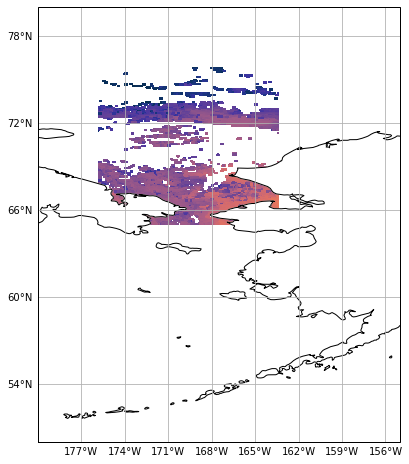

In [35]:
fig,ax = make_map(projection=ccrs.PlateCarree(-160))
for i in range(0,maxdays):
    try:
        print(threddspath[i+1])
        xdf = xa.open_dataset(threddspath[i+1])
        xadf1 = xdf.isel(lat=slice(100,600),lon=slice(100,400))
        plt.pcolormesh(xadf1.lon,xadf1.lat,xadf1[varname.lower()],vmin=-2,vmax=20,transform=ccrs.PlateCarree(),cmap=cmap)
    except:
        pass
    
ax.add_feature(land_50m)
ax.coastlines(resolution='50m')
ax.set_extent(extent)




### SSMI decoder

In [36]:
def decode_datafile(filename,datasource='NRT'):
    icefile = open(filename, 'rb')

    if datasource is 'NRT':
       #remove the header
       icefile.seek(300)
       ice = np.fromfile(icefile,dtype=np.uint8)
       ice[ice >= 253] = 0
       ice = ice/2.5
    elif datasource is 'Bootstrap':
       #no header
       ice = np.fromfile(icefile,dtype=np.uint16)
       ice = ice/10.
       ice[ice == 110] = 0 #110 is land
       ice[ice == 120] = 100 #120 is polar hole
    else:
       ice=np.nan

    return ice;


def get_date(filename):
    icefile = open(filename, 'rb')
    header = icefile.read(300)
    #the date is located btw the following bytes
    date = date=header[219:229].decode() #gets date from header
    date = dt.datetime.strptime(date,"%m/%d/%Y")
    return date;

def decode_latlon(filename):
    latlon_file = open(filename, 'rb')
    output = np.fromfile(latlon_file,dtype='<i4')
    output = output/100000.0
    return output;

In [37]:
fp = '/Users/bell/in_and_outbox/data_sets/nrt_nasatime_seaice/nt_20190828_f18_nrt_n.bin'
ice = decode_datafile(fp,datasource='NRT')

In [38]:
lats_fp='data/psn25lats_v3.dat'
lats = decode_latlon(lats_fp)
lons_fp='data/psn25lons_v3.dat'
lons = decode_latlon(lons_fp)

In [39]:
data={'latitude':decode_latlon(lats_fp), 'longitude':decode_latlon(lons_fp),
      'ice_conc':decode_datafile(fp,'NRT')}
df=pd.DataFrame(data)
df['ice_conc'][df['ice_conc']==0] = np.nan

In [40]:
### Remapping the modes from the analysis
from scipy import interpolate

#-- Now let's grid your data.
# First we'll make a regular grid to interpolate onto. This is equivalent to
# your call to `mgrid`, but it's broken down a bit to make it easier to
# understand. 

#The number of columns and rows can be directly linked to the grid resolution
#360 cols would be 1deg resolution... 180 cols would be 2deg resolution
#the more columns, the slower the gridding process but the smoother the plot.  Too
#many columns will lead to oversampling so .25x.25 is probably the highest I would go

numcols, numrows = 360*4, 90*4
xi = np.linspace(df.longitude.min(), df.longitude.max(), numcols)
yi = np.linspace(df.latitude.min(), df.latitude.max(), numrows)
xi, yi = np.meshgrid(xi, yi)

#-- Interpolate at the points in xi, yi
# "griddata" expects "raw" numpy arrays, so we'll pass in
# data.x.values instead of just the pandas series data.x

# regridding data with 0's removed data
x, y, z = df.longitude.values, df.latitude.values, df.ice_conc.values
zi = interpolate.griddata((x, y),z, (xi, yi), method='linear')

https://opendap.jpl.nasa.gov:443/opendap/OceanTemperature/modis/L3/aqua/4um/v2014.0/4km/daily/2019/234/A2019234.L3m_DAY_SST4_sst4_4km.nc
https://opendap.jpl.nasa.gov:443/opendap/OceanTemperature/modis/L3/aqua/4um/v2014.0/4km/daily/2019/235/A2019235.L3m_DAY_SST4_sst4_4km.nc
https://opendap.jpl.nasa.gov:443/opendap/OceanTemperature/modis/L3/aqua/4um/v2014.0/4km/daily/2019/236/A2019236.L3m_DAY_SST4_sst4_4km.nc
https://opendap.jpl.nasa.gov:443/opendap/OceanTemperature/modis/L3/aqua/4um/v2014.0/4km/daily/2019/237/A2019237.L3m_DAY_SST4_sst4_4km.nc
https://opendap.jpl.nasa.gov:443/opendap/OceanTemperature/modis/L3/aqua/4um/v2014.0/4km/daily/2019/238/A2019238.L3m_DAY_SST4_sst4_4km.nc
https://opendap.jpl.nasa.gov:443/opendap/OceanTemperature/modis/L3/aqua/4um/v2014.0/4km/daily/2019/239/A2019239.L3m_DAY_SST4_sst4_4km.nc
https://opendap.jpl.nasa.gov:443/opendap/OceanTemperature/modis/L3/aqua/4um/v2014.0/4km/daily/2019/240/A2019240.L3m_DAY_SST4_sst4_4km.nc
https://opendap.jpl.nasa.gov:443/opendap/

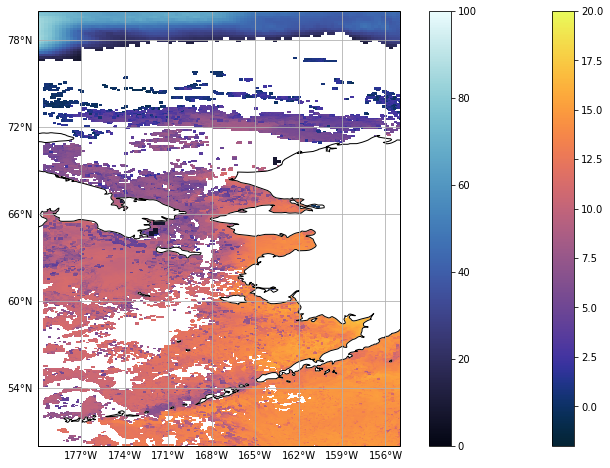

In [41]:
fig,ax = make_map(projection=ccrs.PlateCarree(-160))
for i in range(0,maxdays):
    try:
        print(threddspath[i+1])
        xdf = xa.open_dataset(threddspath[i+1])
        xadf1 = xdf.isel(lat=slice(10,1200),lon=slice(10,800))
        cmt = plt.pcolormesh(xadf1.lon,xadf1.lat,xadf1[varname.lower()],vmin=-2,vmax=20,transform=ccrs.PlateCarree(),cmap=cmap)
    except:
        pass
plt.colorbar(cmt)

    
ax.add_feature(land_50m)
ax.coastlines(resolution='50m')
ax.set_extent(extent)

cm = ax.pcolormesh(xi,yi,zi,transform=ccrs.PlateCarree(),cmap=cmocean.cm.ice, vmin=0, vmax=100)
plt.colorbar(cm)

extent = [-180, -155, 50, 80]
ax.set_extent(extent)


In [42]:
fig.savefig('Modis_SSMI_Composite.png')

### 8Day Modis (4 or 11 um?) 4km or 9km

In [43]:
modis_8d_11um = 'https://opendap.jpl.nasa.gov:443/opendap/OceanTemperature/modis/L3/aqua/11um/v2014.0/4km/8day/2019/A20192092019216.L3m_8D_SST_sst_4km.nc'
modis_8d_4um = 'https://opendap.jpl.nasa.gov:443/opendap/OceanTemperature/modis/L3/aqua/4um/v2014.0/4km/8day/2019/A20192092019216.L3m_8D_SST4_sst4_4km.nc'

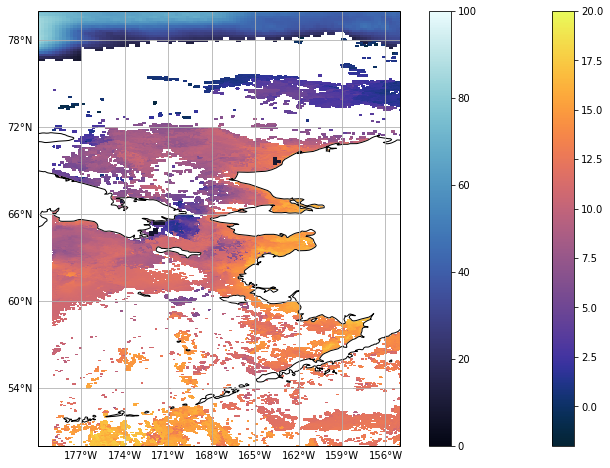

In [44]:
fig,ax = make_map(projection=ccrs.PlateCarree(-160))

xdf = xa.open_dataset(modis_8d_11um)
xadf1 = xdf.isel(lat=slice(10,1200),lon=slice(25,800))

cmt = plt.pcolormesh(xadf1.lon,xadf1.lat,xadf1.sst,vmin=-2,vmax=20,transform=ccrs.PlateCarree(),cmap=cmap)
plt.colorbar(cmt)

ax.add_feature(land_50m)
ax.coastlines(resolution='50m')
ax.set_extent(extent)

cm = ax.pcolormesh(xi,yi,zi,transform=ccrs.PlateCarree(),cmap=cmocean.cm.ice, vmin=0, vmax=100)
plt.colorbar(cm)

ax.set_extent(extent)


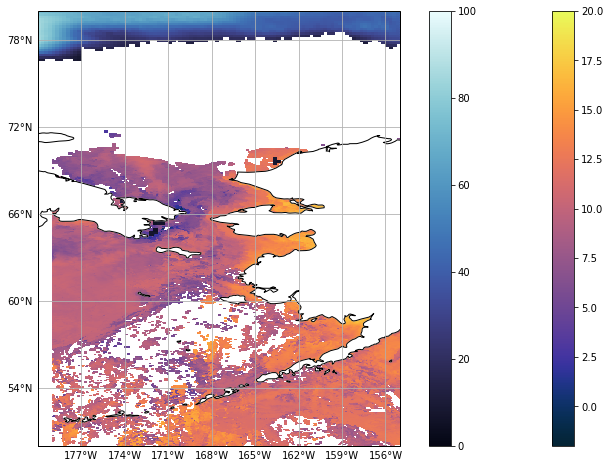

In [45]:
fig,ax = make_map(projection=ccrs.PlateCarree(-160))

xdf = xa.open_dataset(modis_8d_4um)
xadf1 = xdf.isel(lat=slice(10,1200),lon=slice(25,800))

cmt = plt.pcolormesh(xadf1.lon,xadf1.lat,xadf1.sst4,vmin=-2,vmax=20,transform=ccrs.PlateCarree(),cmap=cmap)
plt.colorbar(cmt)

ax.add_feature(land_50m)
ax.coastlines(resolution='50m')
ax.set_extent(extent)

cm = ax.pcolormesh(xi,yi,zi,transform=ccrs.PlateCarree(),cmap=cmocean.cm.ice, vmin=0, vmax=100)
plt.colorbar(cm)

extent = [-180, -155, 50, 80]
ax.set_extent(extent)


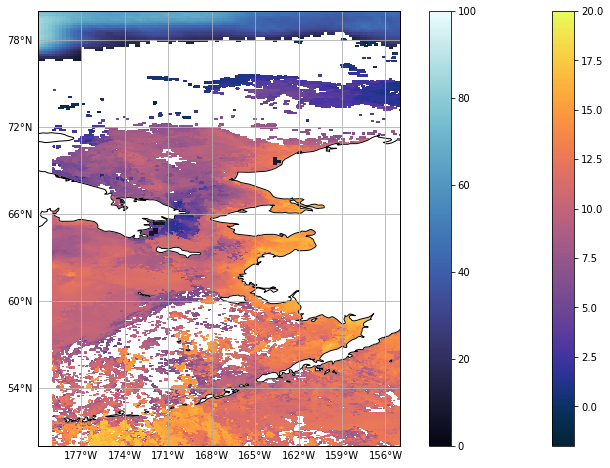

In [46]:
### overlay both channels... no averaging yet
fig,ax = make_map(projection=ccrs.PlateCarree(-160))

xdf = xa.open_dataset(modis_8d_4um)
xadf1 = xdf.isel(lat=slice(10,1200),lon=slice(25,800))
cmt = plt.pcolormesh(xadf1.lon,xadf1.lat,xadf1.sst4,vmin=-2,vmax=20,transform=ccrs.PlateCarree(),cmap=cmap)

xdf = xa.open_dataset(modis_8d_11um)
xadf1 = xdf.isel(lat=slice(10,1200),lon=slice(25,800))
cmt = plt.pcolormesh(xadf1.lon,xadf1.lat,xadf1.sst,vmin=-2,vmax=20,transform=ccrs.PlateCarree(),cmap=cmap)
plt.colorbar(cmt)

ax.add_feature(land_50m)
ax.coastlines(resolution='50m')
ax.set_extent(extent)

cm = ax.pcolormesh(xi,yi,zi,transform=ccrs.PlateCarree(),cmap=cmocean.cm.ice, vmin=0, vmax=100)
plt.colorbar(cm)

extent = [-180, -155, 50, 80]
ax.set_extent(extent)


### compare to MUR

In [ ]:
mur_file = 'https://podaac-opendap.jpl.nasa.gov:443/opendap/allData/ghrsst/data/GDS2/L4/GLOB/JPL/MUR/v4.1/2019/240/20190828090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc'

In [ ]:
fig,ax = make_map(projection=ccrs.PlateCarree(-160))

xdf = xa.open_dataset(mur_file)